### CNN Model Training
Inspired by DSCC_Net

#### Imports

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Load and Split Dataset
80% training, 20% validation

In [2]:
# Load and preprocess images
def load_image(image_name, label):
    image_path = tf.strings.join([image_folder, '/', image_name])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])  # Resize to match the input shape of the CNN
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image, label

# Create a TensorFlow dataset from a DataFrame
def create_tf_dataset(dataframe, image_folder, batch_size=32):
    image_names = dataframe['image'].values
    labels = dataframe['MEL'].values
    dataset = tf.data.Dataset.from_tensor_slices((image_names, labels))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

csv_path = '../preprocessed_dataset/ISIC_2019_Training_Balanced.csv'
image_folder = '../preprocessed_dataset'

# Load the CSV file
df = pd.read_csv(csv_path)
df['image'] = df['image'] + '.jpg'

# Split dataset into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")

# Create TensorFlow datasets for training and validation
train_dataset = create_tf_dataset(train_df, image_folder)
val_dataset = create_tf_dataset(val_df, image_folder)

print("Dataset loaded and preprocessed.")

Training set size: 31117
Validation set size: 7780
Dataset loaded and preprocessed.


#### Preview Dataset

Previewing training dataset:


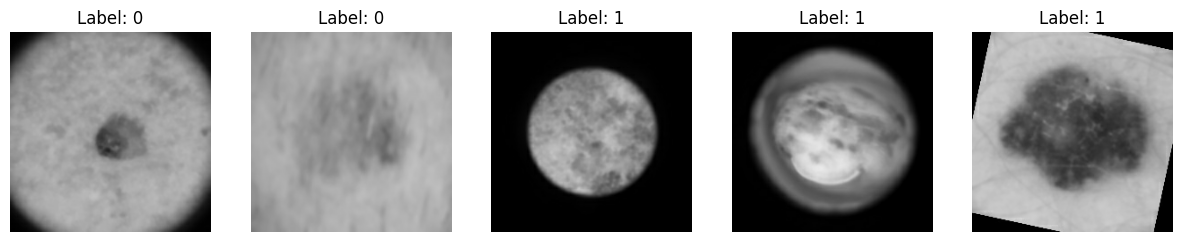

2025-04-23 18:01:01.032219: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Previewing validation dataset:


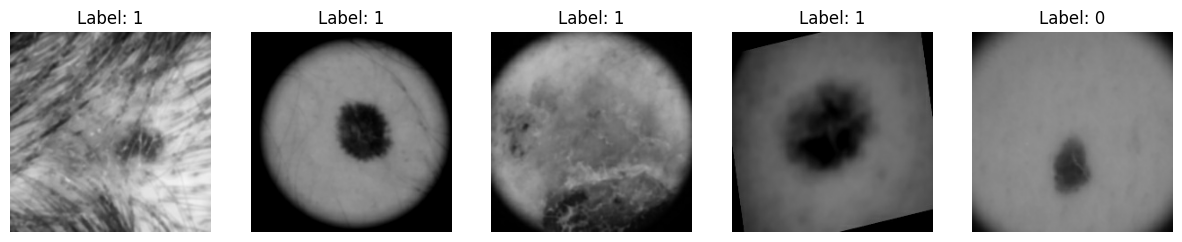

2025-04-23 18:01:01.489835: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [3]:
# Preview a batch of images and labels
def preview_dataset(dataset, num_images=5):
    for images, labels in dataset.take(1):  # Take one batch
        plt.figure(figsize=(15, 15))
        for i in range(num_images):
            ax = plt.subplot(1, num_images, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(f"Label: {int(labels[i].numpy())}")
            plt.axis("off")
        plt.show()

# Preview the training dataset
print("Previewing training dataset:")
preview_dataset(train_dataset)

# Preview the validation dataset
print("Previewing validation dataset:")
preview_dataset(val_dataset)

#### Build the CNN Model

In [ ]:
# build the cnn model from scratch 
def build_cnn_model():
    model = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_initializer='lecun_uniform'),
    layers.BatchNormalization(),
    layers.Dense(1, activation='sigmoid', kernel_initializer='lecun_uniform')  # Output layer for binary classification
    ])
    
    # compile the model
    model.compile(optimizer='adam',
                loss='binary_crossentropy',  # Binary Cross Entropy for binary classification
                metrics=['accuracy'])
    
    return model

# actually build the model
model = build_cnn_model()
# show model architecture
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     1,605,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,886,593 (7.20 MB)

 Trainable params: 1,885,249 (7.19 MB)

 Non-trainable params: 1,344 (5.25 KB)

#### Train the Model

In [ ]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # monitor validation loss
    patience=10,         # wait for 10 epochs for improvement
    restore_best_weights=True,  # restore the best weights when training stops
    verbose=1
)

# Define ModelCheckpoint callback to save the best model
checkpoint = ModelCheckpoint(
    'best_model.keras',  # file where the model will be saved
    monitor='val_loss',  # monitor validation loss
    save_best_only=True,  # save the model only if the validation loss improves
    verbose=1
)

epochs = 30  
batch_size = 32

# Train the model with early stopping and model checkpoint
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping, checkpoint]
)

Epoch 1/25
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7261 - loss: 0.5877
Epoch 1: val_loss improved from inf to 0.47779, saving model to best_model.keras
973/973 ━━━━━━━━━━━━━━━━━━━━ 2470s 3s/step - accuracy: 0.7261 - loss: 0.5876 - val_accuracy: 0.7587 - val_loss: 0.4778
Epoch 2/25
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7598 - loss: 0.4799
Epoch 2: val_loss did not improve from 0.47779
973/973 ━━━━━━━━━━━━━━━━━━━━ 2414s 2s/step - accuracy: 0.7598 - loss: 0.4799 - val_accuracy: 0.7478 - val_loss: 0.4903
Epoch 3/25
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7713 - loss: 0.4631
Epoch 3: val_loss improved from 0.47779 to 0.45947, saving model to best_model.keras
973/973 ━━━━━━━━━━━━━━━━━━━━ 4599s 5s/step - accuracy: 0.7713 - loss: 0.4631 - val_accuracy: 0.7657 - val_loss: 0.4595
Epoch 4/25
973/973 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7791 - loss: 0.4545
Epoch 4: val_loss did not improve from 0.45947
973/973 ━━━━━━━━━━━━━━━━━━━━ 3065s 3s/step 

KeyboardInterrupt: 

#### Evaluate the Model
Binary Cross Entropy Loss

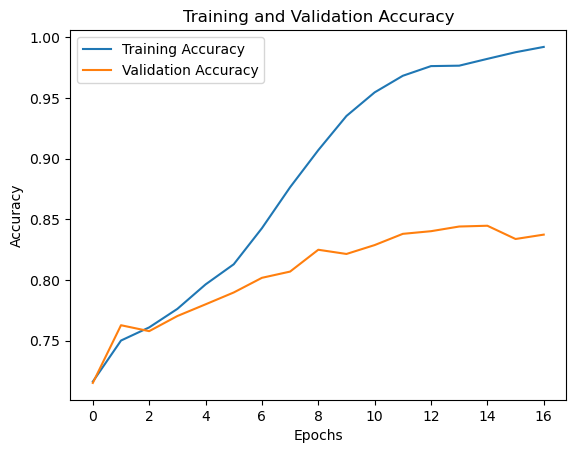

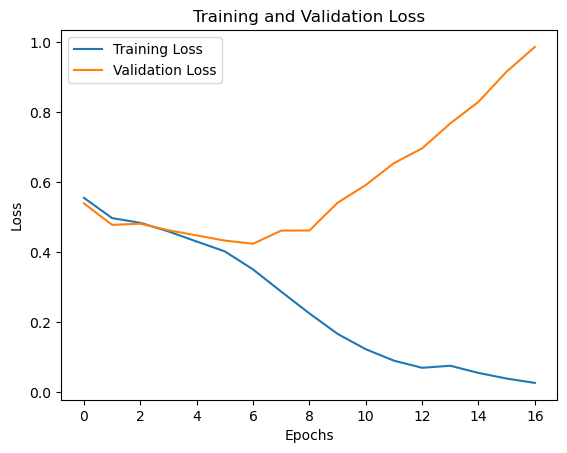

In [7]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()